# 用r2来搜索
改变neg_mean_absolute_error

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('../input/train.csv', index_col='Id')
X_test_full = pd.read_csv('../input/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
# categorical_cols = [cname for cname in X_train_full.columns if
#                     X_train_full[cname].nunique() < 10 and 
#                     X_train_full[cname].dtype == "object"]

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
# 选择基数相对较低的分类列
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]


# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)


In [58]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical data only, as categorical data has already been preprocessed
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols)
    ])


# Define model
model = XGBRegressor(n_jobs=-1)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Define parameter grid
param_grid = {
    'model__n_estimators': [100*i for i in range(1,11)],
    'model__learning_rate': [0.01*i for i in range(1,10)],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(my_pipeline, param_grid, cv=5, scoring='r2')

# print(low_cardinality_cols)
# print(numeric_cols)
# print(X_train.columns)


# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)





{'model__learning_rate': 0.01, 'model__n_estimators': 900}


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.270118      0.009547         0.008978        0.001449   
1       0.623563      0.191931         0.011443        0.006630   
2       0.872385      0.241666         0.008407        0.000209   
3       1.005195      0.025822         0.009339        0.000990   
4       1.260081      0.041052         0.009345        0.000326   

  param_model__learning_rate param_model__n_estimators  \
0                       0.01                       100   
1                       0.01                       200   
2                       0.01                       300   
3                       0.01                       400   
4                       0.01                       500   

                                              params  split0_test_score  \
0  {'model__learning_rate': 0.01, 'model__n_estim...          -0.002563   
1  {'model__learning_rate': 0.01, 'model__n_estim...           0.774042   
2  {'model__learning_ra

/tmp/ipykernel_32/3852245122.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = results.pivot('param_n_estimators', 'param_learning_rate', 'mean_test_score')


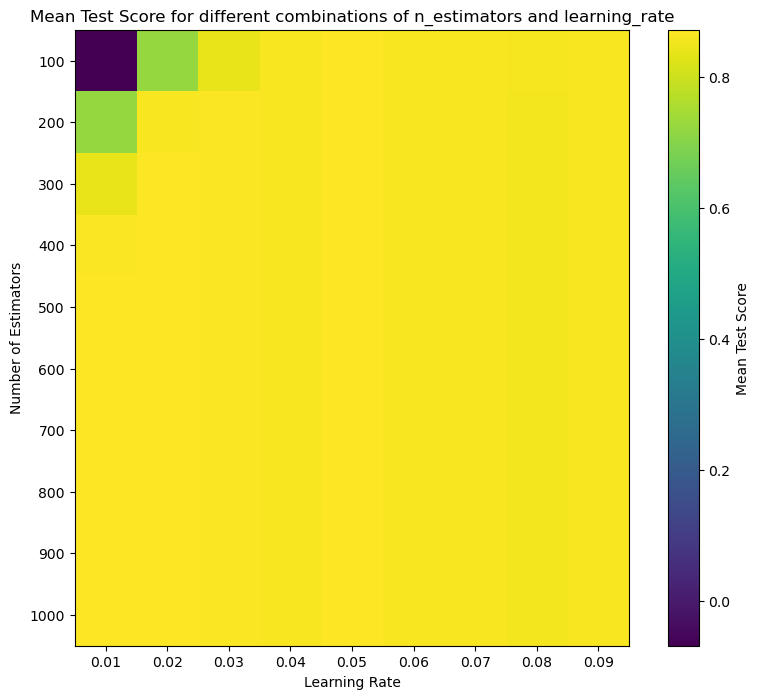

In [59]:
# 使用matplotlib或seaborn等库来绘制结果。例如，你可以创建一个热图来显示不同参数组合的得分：
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 从grid对象中提取结果，并将其转换为DataFrame
results = pd.DataFrame(grid_search.cv_results_)
print(results.head())

# 首先，我们需要将结果数据框中的参数列转换为数值类型，以便在热图中使用
results['param_n_estimators'] = results['param_model__n_estimators'].astype(int)
results['param_learning_rate'] = results['param_model__learning_rate'].astype(float)

# 然后，我们创建一个新的数据框，其中的行和列分别对应于不同的参数值，单元格中的值对应于测试得分
pivot = results.pivot('param_n_estimators', 'param_learning_rate', 'mean_test_score')

# 最后，我们使用matplotlib创建热图
plt.figure(figsize=(10, 8))
plt.imshow(pivot, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Mean Test Score')
plt.xticks(np.arange(len(pivot.columns)), pivot.columns)
plt.yticks(np.arange(len(pivot.index)), pivot.index)
plt.xlabel('Learning Rate')
plt.ylabel('Number of Estimators')
plt.title('Mean Test Score for different combinations of n_estimators and learning_rate')
plt.show()


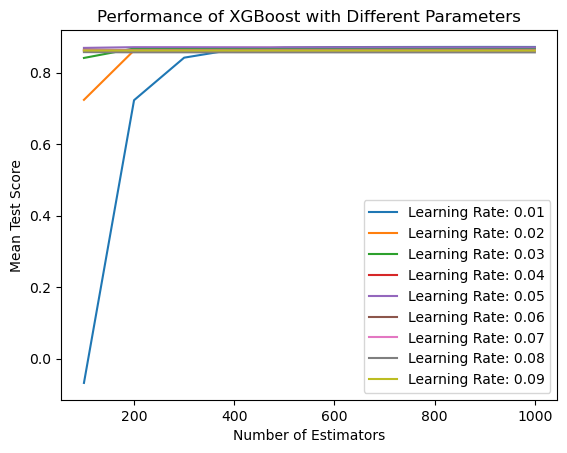

In [60]:
# 画折线图
import matplotlib.pyplot as plt

# 提取结果
n_estimators = results['param_n_estimators']
learning_rate = results['param_learning_rate']
scores = results['mean_test_score']

# 创建一个新的图形
fig, ax = plt.subplots()

# 对于每一个学习率，画一条折线图
for lr in learning_rate.unique():
    # 提取这个学习率的结果
    mask = learning_rate == lr
    ax.plot(n_estimators[mask], scores[mask], label=f'Learning Rate: {lr}')

# 添加图例和标签
ax.legend()
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Mean Test Score')
ax.set_title('Performance of XGBoost with Different Parameters')

# 显示图形
plt.show()


In [61]:
from sklearn.metrics import mean_absolute_error
# 使用最佳参数重新定义模型
best_params = grid_search.best_params_
model = XGBRegressor(n_jobs=-1, 
                     n_estimators=best_params['model__n_estimators'], 
                     learning_rate=best_params['model__learning_rate'])

# 重新定义管道
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# 在训练集上拟合管道
my_pipeline.fit(X_train, y_train)

# 在验证集上评估模型
validation_score = my_pipeline.score(X_valid, y_valid)
print(validation_score)

# Get predictions
predictions = my_pipeline.predict(X_valid)

# Calculate MAE
score = mean_absolute_error(predictions, y_valid)
print('MAE:', score)

# 交叉验证 Evaluate the model using cross_val_score
scores = cross_val_score(my_pipeline, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation scores: ", scores)


0.8406795954404191
MAE: 17413.98810734161
Cross-validation scores:  [0.89940136 0.78435635 0.89577013 0.87017213 0.90913425]


In [62]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)